## Creating Star and Sky Masks for Clusters 
Avi Patel <br>
7/5/2020

__Purpose:__ This program develops star and sky masks for a set of star clusters given there tpfs downloaded from TESScut by adjusting various parameters including the binwidths and the threshold values on the histogram plotting the flux of the targets. 

Each tpf of a given target is casted as a `lightkurve` TESS Target Pixel File, so that we can read and process the flux of each pixel of a cadence as a 2D `numpy` array.

The benefits of these methods are that the star and sky masks can be fine-tuned by adjusting the range of bin widths to be analyzed for each histogram, and by changing the bounds of the maximum number of star pixels that can be returned. Ultimately, we hope to obtain lightcurves of the targets with minimal background noise through fine-tuning these variables.

* __Method 1:__ Inputting an array of various bin widths along with a constant threshold value, this method utilizes ```search_threshold``` to find the star mask that yields the greatest number of pixels below (180x180) - bounds. This method works well, for it yields, for the most part, lightcurves with minimal noise and illustrates proper star and sky masks for each target. However, ```search_threshold``` is very convoluted and implemented in a crude fashion. So, for this reason, method 1 may not be the best way to develop the star and sky masks. \
<br>
* __Method 2:__ Using a fixed binwidth for the histogram, we set a threshold value to categorize pixels on the histogram as being star or sky. Ultimately, we desire to observe a pattern between the threshold value and the optimal number of star pixels, but we benefit from obtaining clean lightcurves through setting this threshold value. 


__Output__: For each target, the optimal binwidth used for the histogram of flux along with the star count and the star and sky masks are returned. The star count is the number of True pixels of the star mask. Both uncorrected and corrected lightcurves are returned as well for each target using the Regression Corrector from `lightkurve` where the user can input the number of PCA components used. 

In [1]:
import numpy as np
import os
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg 
import lightkurve as lk
%matplotlib inline

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 105, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

In [2]:
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":(111.113, -31.85),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}

names = ['NGC 6231','Lambda Orionis','IC 2391','Omega Cen','M7','NGC 3532','Collinder 140','47 Tuc', 'NGC 6752']
#names = ['NGC 752','M34']

L_THRESH = 15
METHOD = 2
BIN_WIDTH = 100
PCA_COMP = 5
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"

In [9]:
def get_tpf(ra,dec):
    for file in os.listdir(LIGHTKURVE_CACHE):
        if file.endswith("180x180_astrocut.fits"): # Confirm size
            if ra == float(file.split("_")[-4]): # Confirm RA
                if dec == float(file.split("_")[-3]): # Confirm dec
                    return lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
    if not foundLocal:
        search = lk.search_tesscut(name)
        char = ""
        if len(search) != 1: char = "s"
        print("{0} has {1} result{2}.".format(self.name, len(search), char))
        return search[0].download(cutout_size=180)

__Method 1:__ Finds the lowest peak in the middle of the histogram by counting the number of bins to the right a bin which have a larger bin height and storing them in a array. The index of the max element of the new array is used to set the threshold.

In [10]:
# Method 1
def search_threshold(arr,bins,mean): # arr is n
    new_arr = np.array([])
    #arr = arr[arr != 0]
    arr = np.flip(arr)
    for i in range(1,len(arr)):  #(1, len(arr))
        count = 0
        for j in range(0,i-1):
            if arr[j] > arr[i] and arr[j] > mean:
                count += 1
        new_arr = np.append(new_arr,count)
    new_arr = np.flip(new_arr)
    element = np.where(new_arr == max(new_arr))[0][-1]
    return  bins[element - 1]

__Method 2:__ Sets a threshold value across the histogram to count star and sky pixels for each target. Default binwidth used is 100.

In [11]:
def horizontalThreshold(n,bins,mean_thresh):
    sky = np.where(n > mean_thresh)
    return bins[max(sky[0])]

In [16]:
class Cluster:
    
    def __init__(self, name, mean_thresh,method):
        self.name = name
        self.tpf = get_tpf(COORDS[name][0],COORDS[name][1])
        #self.tpf = lk.TessTargetPixelFile(dict[name])
        self.frame = self.tpf.shape[0] // 2
        #self.frame = 100
        self.image = self.tpf[self.frame].flux.reshape((180, 180))
        self.mean_thresh = mean_thresh
        self.method = method 
        self.L_thresh = 15
        
    def bin_hist(self, flux_2d,step):
        flux_vals = flux_2d.reshape(180*180)
        bins = np.arange(min(flux_vals),max(flux_vals),step)
        n=10000
        return flux_vals, bins
    
    def plt_hist(self, binwidth,show):
        arr = np.nan_to_num(self.tpf.flux[self.frame])
        f0, b0 = self.bin_hist(arr,binwidth)
        ax0 = plt.figure(figsize=(10,5))
        n, bins, patches = plt.hist(f0,bins=b0,log=True,histtype='bar',label=self.name)
        self.n = n
        self.bins = bins
        if self.method == 1:
            self.U_thresh = search_threshold(self.n,self.bins,self.mean_thresh)
        elif self.method == 2:
            self.U_thresh = horizontalThreshold(self.n,self.bins,self.mean_thresh)
        #plt.axvline(self.U_thresh, color='k', linestyle='dashed', linewidth=1,label="Upper Threshold")
        #plt.axvline(self.L_thresh, color='r', linestyle='dashed', linewidth=1,label="Lower Threshold")
        #plt.axhline(self.mean_thresh,color='k',linestyle='dashed',linewidth=1,label="Horizontal Threshold")
        #plt.legend()
        #plt.close() if show == False else plt.show()
            
        
    
    # Method 2: Sets a threshold to count star and sky pixels. Default binwidth used is 100.
    '''def threshold(self):
        LOW_THRESH = 5 
        self.starMasks = []
        self.skyMasks = []
        sky = np.where(self.n_arr[0] > self.mean_thresh)
        starMask = (self.tpf.flux[self.frame] > self.bin_arr[0][max(sky[0])])
        self.starMasks.append(starMask)
        skyMask = (self.tpf.flux[self.frame] <= self.bin_arr[0][max(sky[0])]) & (self.tpf.flux[self.frame] > LOW_THRESH)
        self.skyMasks.append(skyMask)
        starpixelArr = [sum(self.starMasks[s].reshape(180*180)) for s in range(len(self.starMasks))]
        self.starPixels = max(starpixelArr)
        self.mask_index = np.where(starpixelArr == self.starPixels)[0][0]'''
        


    def create_masks(self):
        self.starMask = (np.nan_to_num(self.tpf.flux[self.frame]) > self.U_thresh)
        self.skyMask = (np.nan_to_num(self.tpf.flux[self.frame]) > self.L_thresh) & (np.nan_to_num(self.tpf.flux[self.frame]) <= self.U_thresh)

        
    def pixelCount(self):
        #"Star Pixel Count: {0}, Sky Pixel Count: {1}".format()
        return sum(self.starMask.reshape(180*180)),sum(self.skyMask.reshape(180*180))
    
    def plot_masks(self):
        skyFlux = np.ma.array(self.tpf[self.frame].flux, mask=~self.skyMask).reshape(180, 180).filled(fill_value=0)
        starFlux = np.ma.array(self.tpf[self.frame].flux, mask=~self.starMask).reshape(180, 180).filled(fill_value=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
        ax1.imshow(skyFlux, vmin=0, vmax=np.nanpercentile(self.tpf[self.frame].flux, 95))
        ax1.set_title(self.name + " sky mask")
        ax2.imshow(starFlux, vmin=0, vmax=np.nanpercentile(self.tpf[self.frame].flux, 95))
        ax2.set_title(self.name + " star mask")

        
    def create_lightcurves(self,PCA):
        self.lc = self.tpf.to_lightcurve(aperture_mask=self.starMask)
        PCA_COMPS = PCA
        regressors = self.tpf.flux[:, self.skyMask]
        regressors = np.nan_to_num(regressors) # Remove nans pixels from tpf 
        dm = lk.DesignMatrix(regressors, name='regressors').pca(PCA_COMPS).append_constant()
        corrector = lk.RegressionCorrector(self.lc)
        self.corrected_lc = corrector.correct(dm)
        
        
        #fig = plt.figure() 
        #p2 = fig.add_subplot(1,1,1)
        '''p1 = self.lc.scatter(color='red');
        p1.set_title(self.name + " Lightcurve")
        p2 = self.corrected_lc.scatter(color='blue');
        p2.set_title(self.name + " Corrected Lightcurve")
        #fig.text((0.5,5),"Threshold Value: {0}".format(self.mean_thresh))
        p2.figure.savefig('{0}_correctedLC.png'.format(self.name))'''
        
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,2.2]})
        
        # Draw cluster
        a = ax1.imshow(self.image, vmax=np.nanpercentile(self.image, 95))
        ax1.set_title(self.name + " average")
        plt.colorbar(a, ax=ax1)
        
        # Cut out outliers
        #CUTOFF_PERCENTILE = 3
        #lowCutoff = np.nanpercentile(self.correctedLC.flux, CUTOFF_PERCENTILE)
        #highCutoff = np.nanpercentile(self.correctedLC.flux, 100 - CUTOFF_PERCENTILE)
        #self.correctedLC.time = self.correctedLC.time[(lowCutoff < self.correctedLC.flux) & (self.correctedLC.flux < highCutoff)]
        #self.correctedLC.flux = self.correctedLC.flux[(lowCutoff < self.correctedLC.flux) & (self.correctedLC.flux < highCutoff)]

        # Draw light curve
        #plot = self.lc.scatter(color='r');# This is where you would flatten the curves
        self.corrected_lc.scatter(ax=ax2, color='k');# This is where you would flatten the curves
        #plot.set_title("TESS 2-min lightcurve for {0}.".format(self.name));
        ax2.set_title("TESS 2-min lightcurve for {0}, corrected.".format(self.name));


Below illustrates method 2 on the sample of clusters. As shown, setting a constant threshold on all objects, in general, masks out a sizable amount of sky pixels and produces clean light curves using a constant bin width for the histograms. Conversely, more must be done to each individual cluster to fine-tune a proper star mask for all by adjusting the threshold value. 

(1243, 31157)
(870, 31530)
(1043, 31357)
(1504, 30896)
(567, 11133)
(1472, 30928)
(703, 21797)
(861, 31539)
(209, 2491)


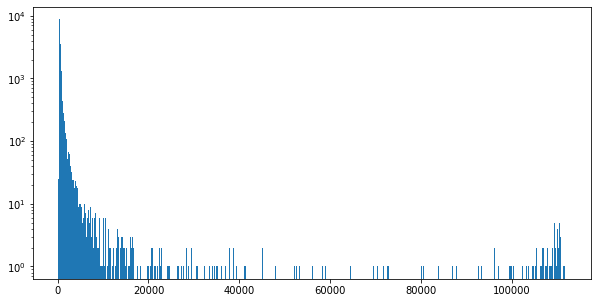

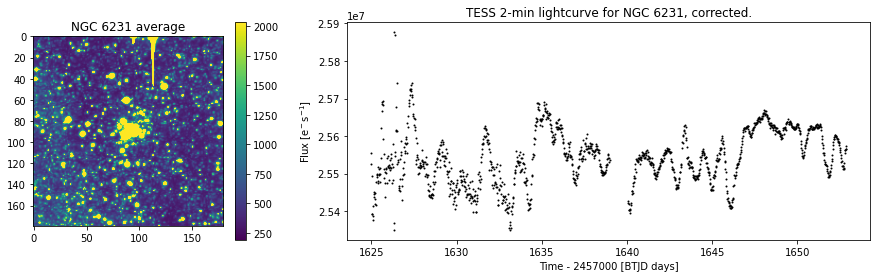

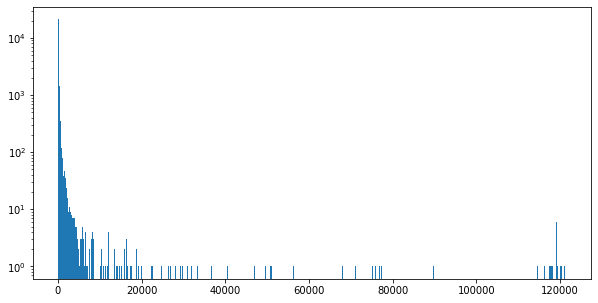

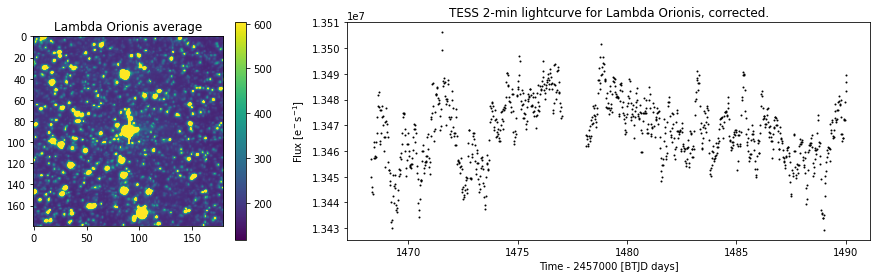

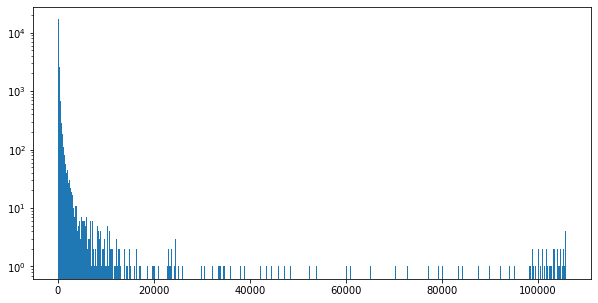

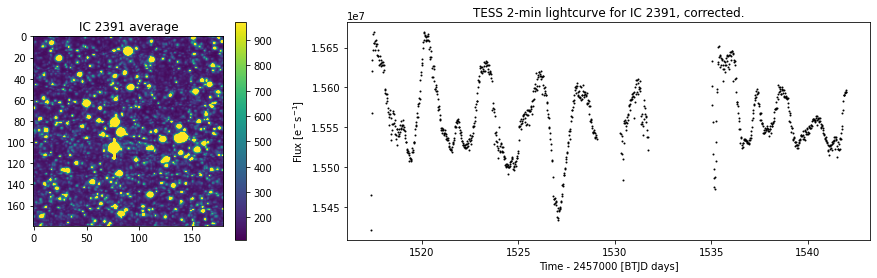

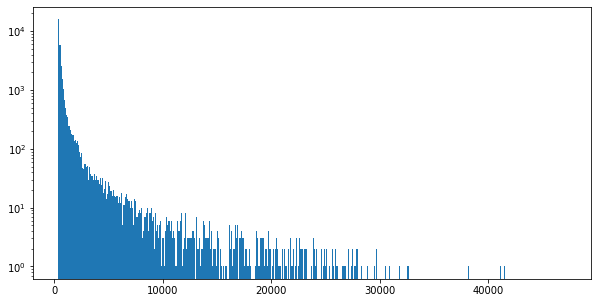

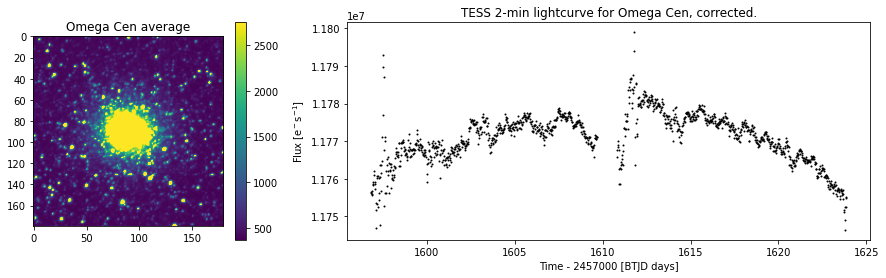

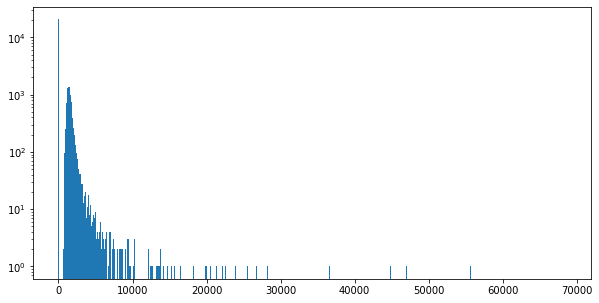

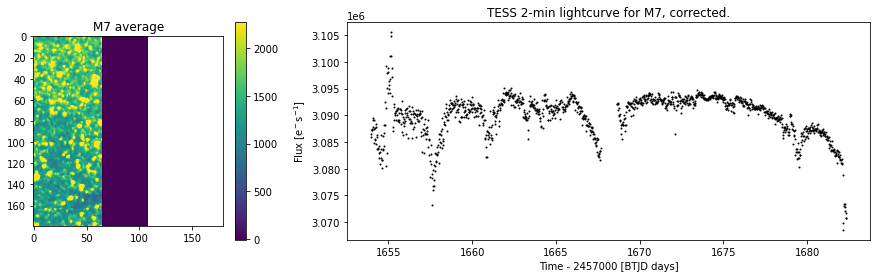

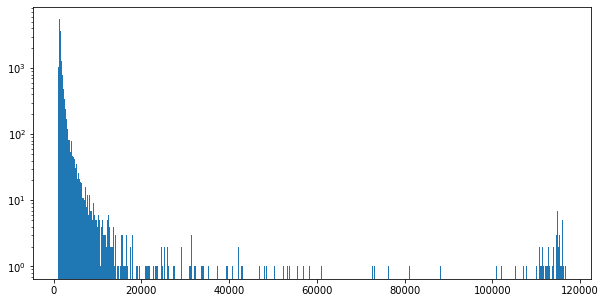

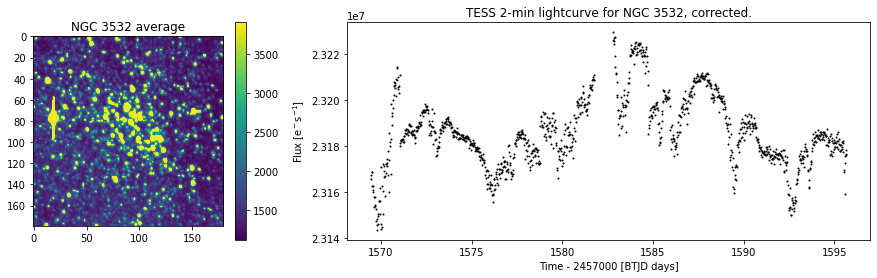

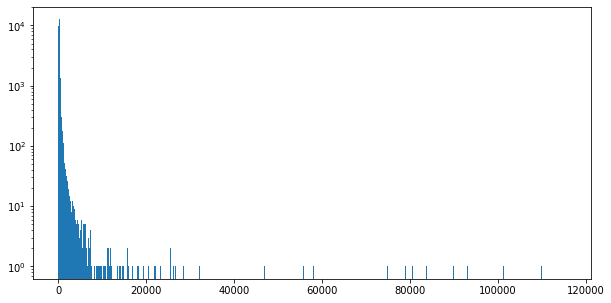

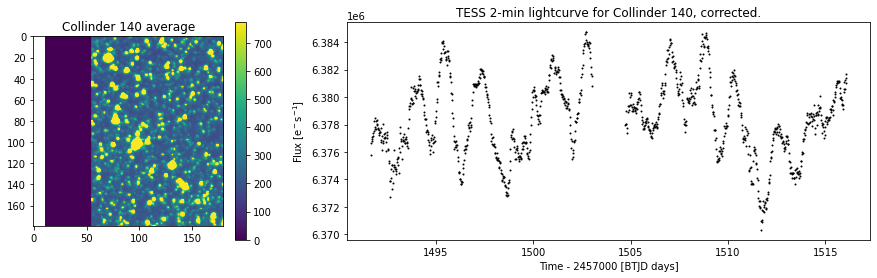

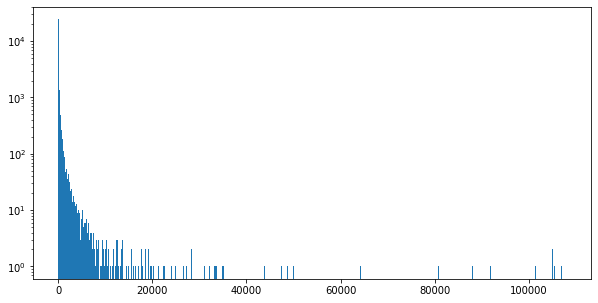

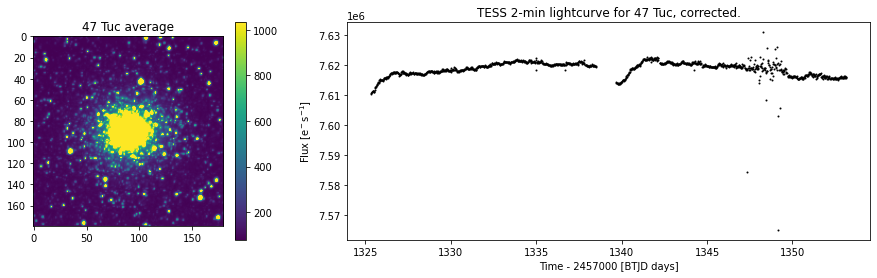

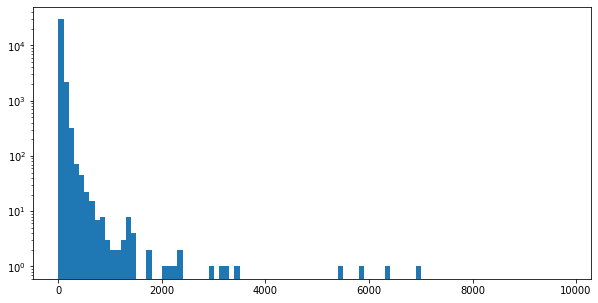

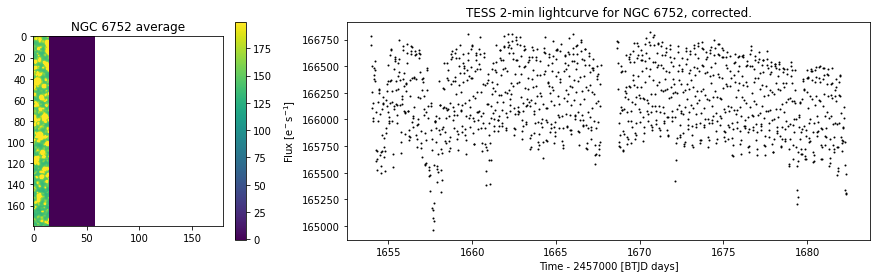

In [17]:
SHOW_HIST = True
MEAN_THRESH = 50
METHOD = 2
#MEAN_THRESH = 50
for i in names:
    c1 = Cluster(i,MEAN_THRESH,METHOD)
    c1.plt_hist(BIN_WIDTH,SHOW_HIST)
    c1.create_masks()
    #c1.plot_masks()
    c1.create_lightcurves(PCA_COMP)
    print(c1.pixelCount())

Find the maximum threshold value for the histogram of each target that yields the largest star pixel count using the method 1 approach. 

In [ ]:
mean_threshs = np.arange(1,21,0.5)
SHOW_HIST = False
METHOD = 1
starPixel_arr = np.array([])
for m in mean_threshs:
    c2 = Cluster(names[4],m,METHOD)
    c2.plt_hist(BIN_WIDTH,SHOW_HIST)
    c2.create_masks()
    #c2.plot_masks()
    star,sky = c2.pixelCount()
    starPixel_arr = np.append(starPixel_arr, star)
element = np.where(starPixel_arr == max(starPixel_arr))[0][0] #The element of mean_threshs which yields highest star pixel count

In [ ]:
SHOW_HIST = True
threshold = 16
c2 = Cluster(names[4],mean_threshs[element],METHOD)
c2.plt_hist(BIN_WIDTH,SHOW_HIST)
c2.create_masks()
c2.plot_masks()
c2.create_lightcurves(PCA_COMP)
print(c2.pixelCount())

In [ ]:
mean_threshs[element]

In [ ]:
starPixel_arr